# Classifying CIFAR10 images 

In [1]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

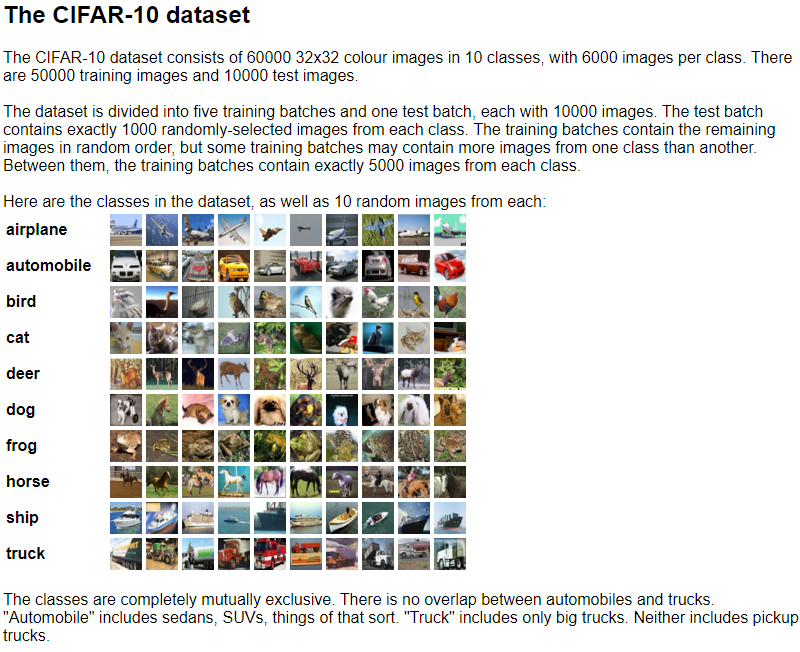

# ***Model 1***

# Exploring Data

In [2]:
dataset = CIFAR10(root = 'data/',train = True,transform=ToTensor(),download=True)

Extracting data/cifar-10-python.tar.gz to data/


In [3]:
classes = dataset.classes

In [4]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
image,label = dataset[0]

In [6]:
image.shape

torch.Size([3, 32, 32])

In [7]:
def show_example(img,label):
  print('Label: ',dataset.classes[label],"("+str(label)+")")
  plt.imshow(img.permute(1,2,0))

Label:  frog (6)


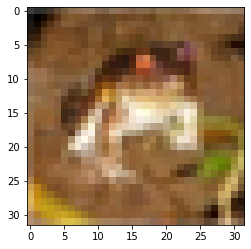

In [8]:
show_example(*dataset[0])

# Training and Validation Datasets

In [9]:
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [10]:
def train_val_data(n,val_pct=0.2):
  n_val = int(val_pct*n)
  indxs = np.random.permutation(n)
  return indxs[n_val:],indxs[:n_val]

In [11]:
train_indices,val_indices = train_val_data(len(dataset))

In [12]:
train_sampler = SubsetRandomSampler(train_indices)

val_sampler = SubsetRandomSampler(val_indices)

In [13]:
batch_size = 100

train_dl = DataLoader(dataset,batch_size,sampler=train_sampler)

val_dl = DataLoader(dataset,batch_size,sampler = val_sampler)

In [14]:
from torchvision.utils import make_grid

In [15]:
def show_batch(dl):
  for images,label in dl:
    fig,ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

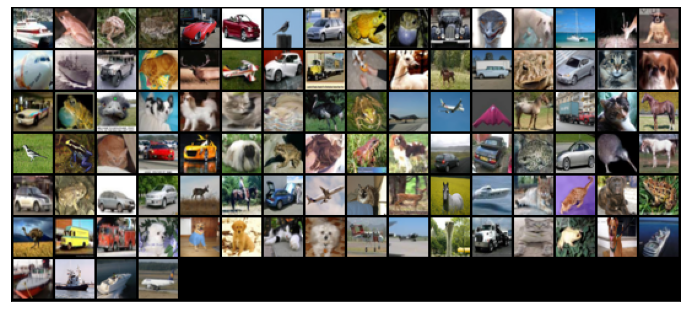

In [16]:
show_batch(train_dl)

# Defining Model

In [17]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
class CIFAR_10Model(ImageClassificationBase):
  def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(512*2*2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
  def forward(self, xb):
        return self.network(xb)

In [21]:
model = CIFAR_10Model()
model

CIFAR_10Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [22]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 10])
out[0]: tensor([ 0.0132,  0.0261,  0.0207, -0.0323,  0.0439,  0.0268, -0.0012,  0.0091,
         0.0430, -0.0024], grad_fn=<SelectBackward>)


# Using GPU

In [23]:
torch.cuda.is_available()

True

In [24]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
to_device(model,device);

# Training the Model


In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history 

In [28]:
model = to_device(CIFAR_10Model(),device)

In [29]:
evaluate(model,val_dl)

{'val_acc': 0.09930000454187393, 'val_loss': 2.30291748046875}

In [30]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
history0 = fit(num_epochs,lr,model,train_dl,val_dl,opt_func)

Epoch [0], train_loss: 2.0123, val_loss: 1.8539, val_acc: 0.3117
Epoch [1], train_loss: 1.5647, val_loss: 1.3974, val_acc: 0.4695
Epoch [2], train_loss: 1.2753, val_loss: 1.1406, val_acc: 0.5894
Epoch [3], train_loss: 1.0728, val_loss: 1.0562, val_acc: 0.6237
Epoch [4], train_loss: 0.9267, val_loss: 0.9194, val_acc: 0.6752
Epoch [5], train_loss: 0.8007, val_loss: 0.8557, val_acc: 0.7026
Epoch [6], train_loss: 0.7018, val_loss: 0.8364, val_acc: 0.7164
Epoch [7], train_loss: 0.6104, val_loss: 0.8191, val_acc: 0.7340
Epoch [8], train_loss: 0.5351, val_loss: 0.8520, val_acc: 0.7211
Epoch [9], train_loss: 0.4580, val_loss: 0.8141, val_acc: 0.7363


In [32]:
history1 = fit(num_epochs,lr,model,train_dl,val_dl,opt_func)

Epoch [0], train_loss: 0.3799, val_loss: 0.8393, val_acc: 0.7445
Epoch [1], train_loss: 0.3038, val_loss: 0.9242, val_acc: 0.7298
Epoch [2], train_loss: 0.2554, val_loss: 1.0258, val_acc: 0.7344
Epoch [3], train_loss: 0.2328, val_loss: 1.0712, val_acc: 0.7325
Epoch [4], train_loss: 0.1934, val_loss: 1.1906, val_acc: 0.7164
Epoch [5], train_loss: 0.1890, val_loss: 1.1938, val_acc: 0.7367
Epoch [6], train_loss: 0.1575, val_loss: 1.2540, val_acc: 0.7324
Epoch [7], train_loss: 0.1559, val_loss: 1.2647, val_acc: 0.7231
Epoch [8], train_loss: 0.1324, val_loss: 1.2835, val_acc: 0.7340
Epoch [9], train_loss: 0.1250, val_loss: 1.3988, val_acc: 0.7355


In [33]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies,'-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs no of epochs');

In [34]:
history = history0+history1

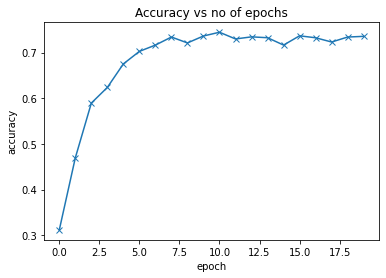

In [35]:
plot_accuracies(history)

Our model reaches an accuracy of around 74% and by looking at the graph,it seems unlikey that the model will achieve an accuracy higher than 80% even after training for a long time

In [36]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

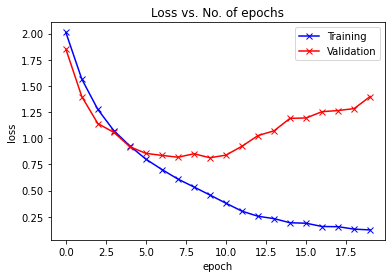

In [37]:
plot_losses(history)

From this graph we can see that the model is **overfitting**.

To over come the problem of **overfitting** we will do data augmentation and channel-wise normalization

# ***Model 2***

# Preparing the Data

*   Use test set for validation
*   Channel-wise data normalization
*   Randomized data augmentations



In [38]:
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import tarfile

In [56]:
images_labels = dataset[0]
images.shape

torch.Size([100, 3, 32, 32])

In [95]:
imgs=[];
for img,label in dataset:
  img_arr = np.array(img)/255
  imgs.append(img_arr)

In [58]:
imgs = np.stack(imgs)

In [59]:
reds,greens,blues = imgs[:,:,:,0],imgs[:,:,:,1],imgs[:,:,:,2]

In [60]:
means = np.mean(reds),np.mean(greens),np.mean(blues)

In [61]:
std = np.std(reds),np.std(greens),np.std(blues)

In [62]:
means,std

((0.49139967861519745, 0.4821584083946076, 0.44653091444546616),
 (0.2470322324632823, 0.24348512800005553, 0.2615878417279641))

In [63]:
reds.shape

(50000, 32, 32)

In [64]:
stats = means,std

## Mean and Standard deviation

In [65]:
stats

((0.49139967861519745, 0.4821584083946076, 0.44653091444546616),
 (0.2470322324632823, 0.24348512800005553, 0.2615878417279641))

In [50]:
import torchvision.transforms as tt

# Transformation

*   normalization
*   Data augmentation



In [55]:
train_tfms = tt.Compose(
    [
     tt.RandomCrop(32,padding =4,padding_mode = 'reflect'),
     tt.RandomHorizontalFlip(),
     tt.ToTensor(),
     tt.Normalize(*stats,inplace=True)
    ]
)

test_tfms = tt.Compose(
    [
     tt.ToTensor(),
     tt.Normalize(*stats)
    ]
)

In [67]:
train_dataset = CIFAR10(root = 'data/',train=True,download=True,transform=train_tfms)

Files already downloaded and verified


In [68]:
test_dataset = CIFAR10(root='data/',train=False,download=True,transform=test_tfms)

Files already downloaded and verified


In [69]:
len(train_dataset)

50000

In [70]:
img,_ = train_dataset[0]

# Comparison between the images before and after data transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


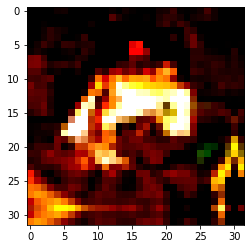

In [72]:
plt.imshow(img.permute(1,2,0))

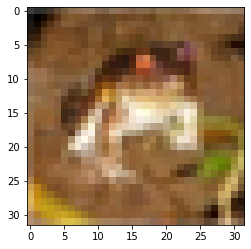

In [73]:
img,_ = dataset[0]
plt.imshow(img.permute(1,2,0))

In [74]:
batch_size = 250

In [75]:
train_dataloader = DataLoader(train_dataset,batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_dataloader = DataLoader(test_dataset,batch_size*2,num_workers=3,pin_memory=True)

In [79]:
def show_batch(dl):
  for images,labels in dl:
    fig,ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


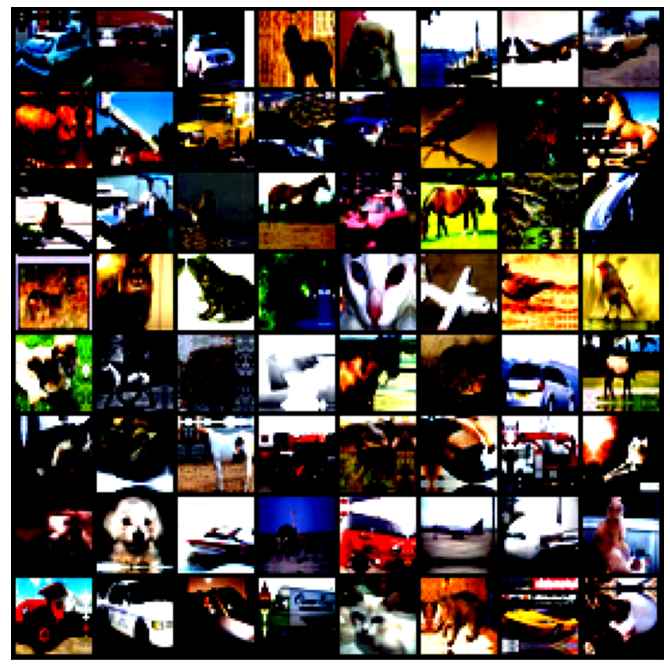

In [80]:
show_batch(train_dataloader)

# Using GPU

In [81]:
device1 = get_default_device()

In [82]:
device1

device(type='cuda')

In [83]:
train_dl = DeviceDataLoader(train_dataloader,device1)
val_dl = DeviceDataLoader(val_dataloader,device1)

# Training the Model

In [87]:
model2 = to_device(CIFAR_10Model(),device1)
model2

CIFAR_10Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [88]:
evaluate(model2,val_dl)

{'val_acc': 0.10000000149011612, 'val_loss': 2.3029391765594482}

In [89]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [90]:
history = fit(num_epochs,lr,model2,train_dl,val_dl,opt_func)

Epoch [0], train_loss: 1.9297, val_loss: 1.7409, val_acc: 0.3050
Epoch [1], train_loss: 1.4743, val_loss: 1.2501, val_acc: 0.5444
Epoch [2], train_loss: 1.1734, val_loss: 1.0716, val_acc: 0.6122
Epoch [3], train_loss: 0.9723, val_loss: 0.9261, val_acc: 0.6695
Epoch [4], train_loss: 0.8501, val_loss: 0.7819, val_acc: 0.7206
Epoch [5], train_loss: 0.7514, val_loss: 0.6982, val_acc: 0.7624
Epoch [6], train_loss: 0.6668, val_loss: 0.6658, val_acc: 0.7759
Epoch [7], train_loss: 0.6109, val_loss: 0.6278, val_acc: 0.7877
Epoch [8], train_loss: 0.5609, val_loss: 0.5968, val_acc: 0.8055
Epoch [9], train_loss: 0.5304, val_loss: 0.5719, val_acc: 0.8058


In [91]:
history += fit(num_epochs,lr,model2,train_dl,val_dl,opt_func)

Epoch [0], train_loss: 0.5041, val_loss: 0.5136, val_acc: 0.8293
Epoch [1], train_loss: 0.4665, val_loss: 0.5643, val_acc: 0.8153
Epoch [2], train_loss: 0.4432, val_loss: 0.5068, val_acc: 0.8322
Epoch [3], train_loss: 0.4132, val_loss: 0.4734, val_acc: 0.8439
Epoch [4], train_loss: 0.3959, val_loss: 0.5172, val_acc: 0.8309
Epoch [5], train_loss: 0.3853, val_loss: 0.4855, val_acc: 0.8380
Epoch [6], train_loss: 0.3675, val_loss: 0.4781, val_acc: 0.8493
Epoch [7], train_loss: 0.3476, val_loss: 0.4533, val_acc: 0.8533
Epoch [8], train_loss: 0.3342, val_loss: 0.4963, val_acc: 0.8348
Epoch [9], train_loss: 0.3223, val_loss: 0.4856, val_acc: 0.8524


In [92]:
history += fit(num_epochs,lr,model2,train_dl,val_dl,opt_func)

Epoch [0], train_loss: 0.3169, val_loss: 0.4559, val_acc: 0.8557
Epoch [1], train_loss: 0.3089, val_loss: 0.4339, val_acc: 0.8634
Epoch [2], train_loss: 0.2879, val_loss: 0.4478, val_acc: 0.8571
Epoch [3], train_loss: 0.2853, val_loss: 0.4395, val_acc: 0.8609
Epoch [4], train_loss: 0.2713, val_loss: 0.4426, val_acc: 0.8604
Epoch [5], train_loss: 0.2614, val_loss: 0.4703, val_acc: 0.8562
Epoch [6], train_loss: 0.2586, val_loss: 0.4776, val_acc: 0.8533
Epoch [7], train_loss: 0.2564, val_loss: 0.4743, val_acc: 0.8548
Epoch [8], train_loss: 0.2417, val_loss: 0.4590, val_acc: 0.8638
Epoch [9], train_loss: 0.2377, val_loss: 0.5011, val_acc: 0.8534


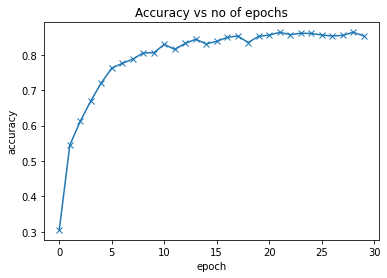

In [93]:
plot_accuracies(history)

This model reaches an accuracy of around **86%** and by looking at the graph.it seems unlikely that the model will achieve an accuracy higher than **90%**.But we were able to increase the accuracy from **74%** to **86%** by doing normalization and data agumentation

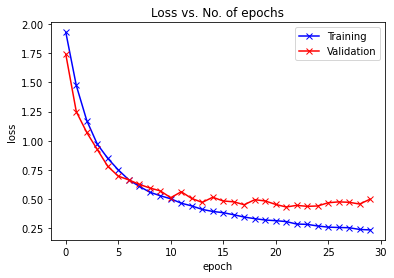

In [94]:
plot_losses(history)

From this graph we can see that the model is **overfitting**.But the overfitting is less compared to first model

We were able to increase the **accuracy** and decrease the **loss** from the first model